# Distance Plot
Notebook that generates a box-and-whisker plot for a given dataset.

### Configure Paths
In `MARIAM/data/` each folder is a *dataset*. Each dataset consists of a subfolder of trials for each controller type:
- `<MM-DD>_p_experiments/`: Data from position controller trials.
- `<MM-DD>_a_experiments/`: Data from admittance controller trials.
- `<MM-DD>_dp_experiments/`: Data from dynamic parameterization controller trials. 

Each trial folder consists of the following files:
- `monica_admittance_data.csv`: Admittance and manipulator data for Monica.
- `ross_admittance_data.csv`: Admittance and manipulator data for Ross.
- `trajectory_data.csv`: Locations and orientations of the payload, Monica, and Ross.

In [9]:
# Dataset path
dataset_name = '08-30_dataset'
dataset_path = f'../../data/{dataset_name}/'

# Controller type paths
dp_experiments_path = f'{dataset_path}08-30_dp_experiments/'
a_experiments_path = f'{dataset_path}08-30_a_experiments/'
p_experiments_path = f'{dataset_path}08-30_p_experiments/'

### Create Data Structure
All csv data across all trials will be organized in a singular data structure with the following format:
```python
data = {
    'p': {  # position controller
        'trial_01': {
            'trajectory': DataFrame,
            'monica_admittance': DataFrame, 
            'ross_admittance': DataFrame
        },
        'trial_02': { ... },
        ...
    },
    'a': { ... },  # admittance controller  
    'dp': { ... }  # dynamic parameterization controller
}
```

In [10]:
import pandas as pd
import os
import re
from pathlib import Path

def load_experiment_data(dataset_path):
    """
    Load all robotic experiment data without preprocessing.
    
    Args:
        dataset_path: Path to the main dataset folder (e.g., '../../data/08-30_dataset/')
    
    Returns:
        dict: Nested dictionary with structure data[controller][trial_num][file_type]
    """
    
    data = {}
    date_prefix = Path(dataset_path).name.split('_')[0]
    
    # File naming conventions by controller type
    file_mappings = {
        'p': {'monica': 'monica_position_data.csv', 'ross': 'ross_position_data.csv'},
        'a': {'monica': 'monica_admittance_data.csv', 'ross': 'ross_admittance_data.csv'},
        'dp': {'monica': 'monica_admittance_data.csv', 'ross': 'ross_admittance_data.csv'}
    }
    
    for controller in ['p', 'a', 'dp']:
        controller_path = os.path.join(dataset_path, f"{date_prefix}_{controller}_experiments")
        
        if not os.path.exists(controller_path):
            print(f"Warning: Path {controller_path} does not exist.")
            continue
            
        print(f"Loading {controller} controller data...")
        data[controller] = {}
        
        # Process all trial folders
        trial_folders = [f for f in os.listdir(controller_path) 
                        if os.path.isdir(os.path.join(controller_path, f)) and 'trial' in f]
        
        for trial_folder in sorted(trial_folders):
            trial_match = re.search(r'trial_(\d+)', trial_folder)
            if not trial_match:
                continue
                
            trial_num = trial_match.group(1)
            trial_path = os.path.join(controller_path, trial_folder)
            
            # Load trajectory data
            trajectory_file = os.path.join(trial_path, 'trajectory_data.csv')
            if not os.path.exists(trajectory_file):
                print(f"  Warning: trajectory_data.csv not found in trial {trial_num}")
                continue
            
            try:
                data[controller][trial_num] = {
                    'trajectory': pd.read_csv(trajectory_file)
                }
                
                # Load monica and ross data files
                for robot, filename in file_mappings[controller].items():
                    file_path = os.path.join(trial_path, filename)
                    if os.path.exists(file_path):
                        try:
                            data[controller][trial_num][f"{robot}_{controller}"] = pd.read_csv(file_path)
                        except Exception as e:
                            print(f"    Error loading {filename} in trial {trial_num}: {e}")
                    else:
                        print(f"    Warning: {filename} not found in trial {trial_num}")
                
            except Exception as e:
                print(f"  Error loading trial {trial_num}: {e}")
    
    # Summary
    print("\n" + "="*40)
    print("LOADING SUMMARY")
    print("="*40)
    total_trials = 0
    for controller in data:
        trial_count = len(data[controller])
        total_trials += trial_count
        print(f"{controller.upper()}: {trial_count} trials")
    print(f"Total: {total_trials} trials")
    
    return data
    

data = load_experiment_data(dataset_path=dataset_path)

Loading p controller data...
    Error loading ross_position_data.csv in trial 07: No columns to parse from file
    Error loading ross_position_data.csv in trial 20: No columns to parse from file
    Error loading ross_position_data.csv in trial 22: No columns to parse from file
Loading a controller data...
    Error loading ross_admittance_data.csv in trial 24: No columns to parse from file
Loading dp controller data...

LOADING SUMMARY
P: 20 trials
A: 20 trials
DP: 26 trials
Total: 66 trials


### Data Pre-Processing
Each The monica and ross CSV files for each trial will be cropped to the start and end times of the `trajectory_data.csv` file.

In [11]:
def crop_experiment_data(data):
    """
    Crop all non-trajectory data to match trajectory time bounds.
    
    Args:
        data: Data structure from load_experiment_data()
    
    Returns:
        dict: Same structure with cropped data
    """
    
    cropped_data = {}
    
    for controller in data:
        print(f"Cropping {controller} controller data...")
        cropped_data[controller] = {}
        
        for trial_num in data[controller]:
            trial_data = data[controller][trial_num]
            
            # Get time bounds from trajectory data
            trajectory_df = trial_data['trajectory']
            start_time = trajectory_df['ros_time_ns'].min()
            end_time = trajectory_df['ros_time_ns'].max()
            
            # Initialize with trajectory data (no cropping needed)
            cropped_data[controller][trial_num] = {
                'trajectory': trajectory_df.copy()
            }
            
            # Crop all other data files
            for data_type, df in trial_data.items():
                if data_type == 'trajectory':
                    continue
                    
                if 'ros_time_ns' not in df.columns:
                    print(f"    Warning: ros_time_ns column not found in {data_type}, trial {trial_num}")
                    cropped_data[controller][trial_num][data_type] = df.copy()
                    continue
                
                # Crop to trajectory time range
                original_length = len(df)
                cropped_df = df[(df['ros_time_ns'] >= start_time) & (df['ros_time_ns'] <= end_time)].copy()
                
                # Check coverage and warn if incomplete
                df_start, df_end = df['ros_time_ns'].min(), df['ros_time_ns'].max()
                if df_start > start_time or df_end < end_time:
                    print(f"    Warning: {data_type} trial {trial_num} doesn't fully cover trajectory time range")
                
                # print(f"    {data_type} trial {trial_num}: {original_length} -> {len(cropped_df)} rows")
                cropped_data[controller][trial_num][data_type] = cropped_df
    
    print("\nCropping complete!")
    return cropped_data

processed_data = crop_experiment_data(data=data)

Cropping p controller data...
Cropping a controller data...
Cropping dp controller data...

Cropping complete!


### Plot Forces
For every trial, plot force over time for Monica and Ross

Plotting p controller data...


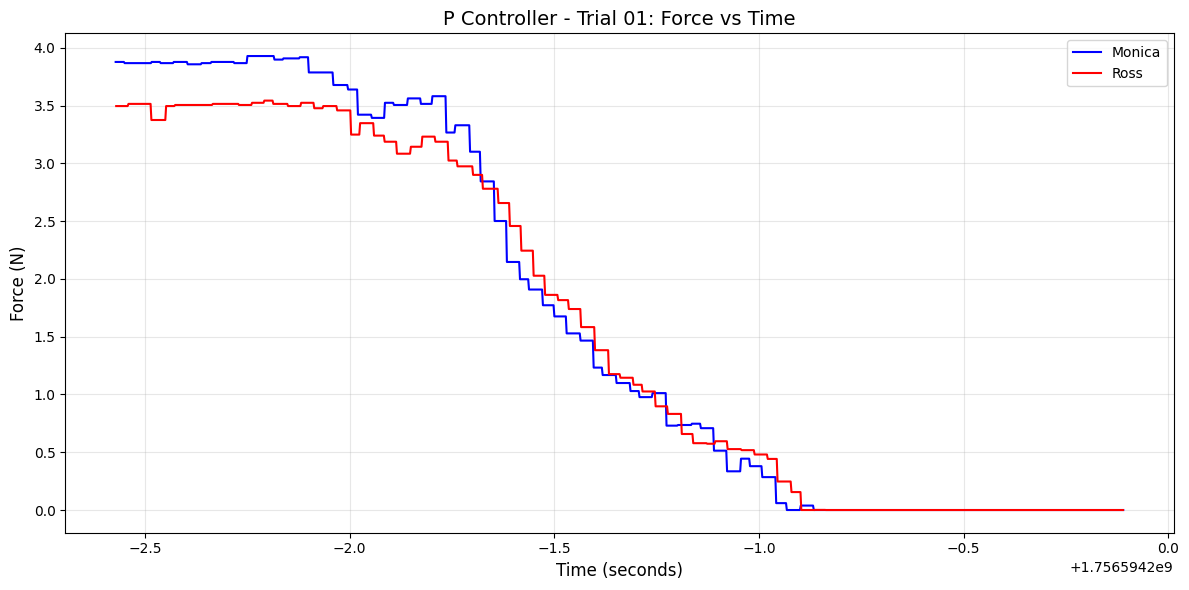

  Example plot shown: p_trial_01.png
  Saved: p_trial_01.png
  Saved: p_trial_02.png
  Saved: p_trial_03.png
  Saved: p_trial_04.png
  Saved: p_trial_05.png
  Saved: p_trial_06.png
  Saved: p_trial_07.png
  Saved: p_trial_08.png
  Saved: p_trial_09.png
  Saved: p_trial_10.png
  Saved: p_trial_16.png
  Saved: p_trial_17.png
  Saved: p_trial_18.png
  Saved: p_trial_19.png
  Saved: p_trial_20.png
  Saved: p_trial_21.png
  Saved: p_trial_22.png
  Saved: p_trial_23.png
  Saved: p_trial_24.png
  Saved: p_trial_25.png
Plotting a controller data...
  Saved: a_trial_01.png
  Saved: a_trial_02.png
  Saved: a_trial_03.png
  Saved: a_trial_04.png
  Saved: a_trial_05.png
  Saved: a_trial_06.png
  Saved: a_trial_07.png
  Saved: a_trial_08.png
  Saved: a_trial_09.png
  Saved: a_trial_10.png
  Saved: a_trial_16.png
  Saved: a_trial_17.png
  Saved: a_trial_18.png
  Saved: a_trial_19.png
  Saved: a_trial_20.png
  Saved: a_trial_21.png
  Saved: a_trial_22.png
  Saved: a_trial_23.png
  Saved: a_trial_24.p

In [12]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Create figures directory
figures_dir = f'raw_data_visualizations/{dataset_name}/'
os.makedirs(figures_dir, exist_ok=True)

def plot_forces_for_trial(controller, trial_num, trial_data, save_path):
    """
    Plot Monica and Ross forces over time for a single trial.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot Monica force if available
    monica_key = f'monica_{controller}'
    if monica_key in trial_data and 'force' in trial_data[monica_key].columns:
        monica_df = trial_data[monica_key]
        ax.plot(monica_df['ros_time_sec'], monica_df['force'], 
                label='Monica', color='blue', linewidth=1.5)
    
    # Plot Ross force if available
    ross_key = f'ross_{controller}'
    if ross_key in trial_data and 'force' in trial_data[ross_key].columns:
        ross_df = trial_data[ross_key]
        ax.plot(ross_df['ros_time_sec'], ross_df['force'], 
                label='Ross', color='red', linewidth=1.5)
    
    # Formatting
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Force (N)', fontsize=12)
    ax.set_title(f'{controller.upper()} Controller - Trial {trial_num}: Force vs Time', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Save figure
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    return fig

# Plot forces for all trials across all controllers
total_plots = 0
example_shown = False

for controller in processed_data:
    print(f"Plotting {controller} controller data...")
    
    for trial_num in sorted(processed_data[controller].keys()):
        trial_data = processed_data[controller][trial_num]
        
        # Check if we have force data for this trial
        has_monica = f'monica_{controller}' in trial_data and 'force' in trial_data[f'monica_{controller}'].columns
        has_ross = f'ross_{controller}' in trial_data and 'force' in trial_data[f'ross_{controller}'].columns
        
        if not (has_monica or has_ross):
            print(f"  Skipping trial {trial_num} - no force data available")
            continue
        
        # Create filename and save path
        filename = f'{controller}_trial_{trial_num.zfill(2)}.png'
        save_path = os.path.join(figures_dir, filename)
        
        # Create the plot
        fig = plot_forces_for_trial(controller, trial_num, trial_data, save_path)
        total_plots += 1
        
        # Show first plot as example
        if not example_shown:
            plt.figure(figsize=(12, 6))
            
            # Recreate the plot for display
            monica_key = f'monica_{controller}'
            ross_key = f'ross_{controller}'
            
            if monica_key in trial_data and 'force' in trial_data[monica_key].columns:
                monica_df = trial_data[monica_key]
                plt.plot(monica_df['ros_time_sec'], monica_df['force'], 
                        label='Monica', color='blue', linewidth=1.5)
            
            if ross_key in trial_data and 'force' in trial_data[ross_key].columns:
                ross_df = trial_data[ross_key]
                plt.plot(ross_df['ros_time_sec'], ross_df['force'], 
                        label='Ross', color='red', linewidth=1.5)
            
            plt.xlabel('Time (seconds)', fontsize=12)
            plt.ylabel('Force (N)', fontsize=12)
            plt.title(f'{controller.upper()} Controller - Trial {trial_num}: Force vs Time', fontsize=14)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            example_shown = True
            print(f"  Example plot shown: {filename}")
        
        print(f"  Saved: {filename}")

print(f"\n{'='*50}")
print(f"PLOTTING COMPLETE")
print(f"{'='*50}")
print(f"Total plots created: {total_plots}")
print(f"Figures saved to: {figures_dir}")

# List all created files
created_files = [f for f in os.listdir(figures_dir) if f.endswith('.png')]
print(f"Created files: {len(created_files)}")
for f in sorted(created_files)[:10]:  # Show first 10 files
    print(f"  - {f}")
if len(created_files) > 10:
    print(f"  ... and {len(created_files) - 10} more files")